## Lesson 9 in a nutshell

-   Basic ideas from Jeremy Howard's video: The three components of stable diffusion
-   9a: Deep Dive where you can use Stable Diffusion directly, then look under the hood
-   9b: A bit of the mathematics
-   Have to stay big picture, but make sure to understand the words used

## Definitions

-   Model: The boxes that Jeremy draws, the magic function
-   Sample: Image
-   Diffusion models: Machine learning systems that are trained to denoise random Gaussian noise step by step
-   Latent: A lower dimensional representation of an image
-   Inference: Use existing model to generate samples
-   Training: Fine-tuning using new data (Not covered in Lesson 9)

## Use Stable Diffusion directly

If you just want to generate images casually, the following commands are sufficient but these are modified from the original Stable Diffusion Deep Dive notebook. 

-   Used paperspace (now with DigitalOcean) Start from Scratch machine setting. 
-   Must change the transformers versions to 4.28.0 or more. 
-   Load the minimal libraries. 
-   You still need an access token for HuggingFace. Otherwise, you cannot generate the images. 
-   But `StableDiffusionPipeline` will ignore `use_auth_token=True`. 

In [1]:
!pip install -q --upgrade transformers==4.28.0 diffusers ftfy accelerate

In [2]:
from diffusers import StableDiffusionPipeline
import torch
from pathlib import Path
from huggingface_hub import notebook_login

if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", variant="fp16", torch_dtype=torch.float16).to("cuda")

2024-09-04 22:17:11.427178: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 22:17:11.427227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 22:17:11.428871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 22:17:11.438463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 22:17:12.773437: W tensorflow/compiler/tf2

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

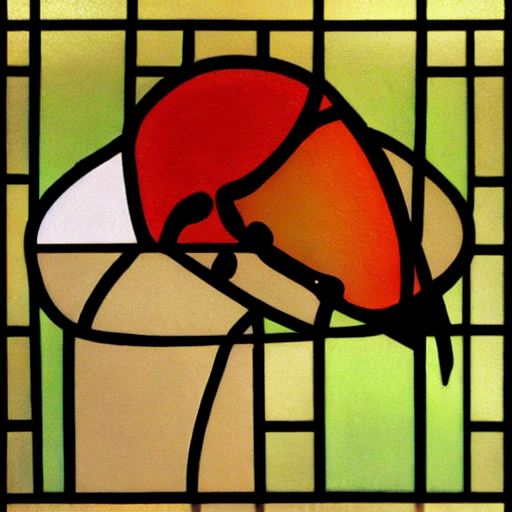

In [3]:
torch.manual_seed(1)
image = pipe("A fruit fly sipping a white Russian in the style of a stained glass painting").images[0]
image

In [3]:
!pip install -Uq fastcore

In [ ]:
from fastcore.all import concat
torch.manual_seed(1)
num_rows,num_cols = 4, 4
prompt = "A fruit fly sipping a white Russian in the style of a stained glass painting"
prompts = [prompt] * num_cols
images = concat(pipe(prompts, guidance_scale=g).images for g in [1,3,7.5,14])

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

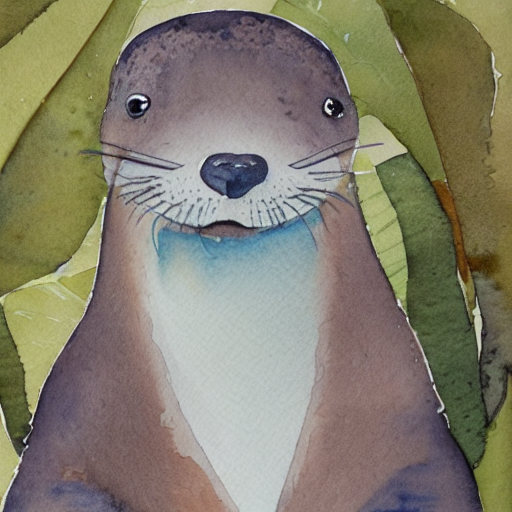

In [5]:
image = pipe("A watercolor painting of an otter", 
             height = 512, 
             width = 512, 
             num_inference_steps = 30,
             guidance_scale = 7.5, 
             generator = torch.manual_seed(32),
             batch_size = 1).images[0]
image

## Customizing Stable Diffusion

-   Three separate components: CLIP, VAE, U-Net
-   CLIP 
    
    -   Input: text prompt, collected alt text used for accessibility
    -   Output: embeddings
    -   Target: consonance of text and images which are related to text
    -   Loss: contrastive loss
    
-   VAE

    -   Two components: encoder and decoder
    -   Encoder input: image
    -   Encoder output: latent representation
    -   Decoder input: latent representation
    -   Decoder output: image
    -   Target: encoder input should roughly be the same as decoder output

-   U-Net

    -   Input: actual pure noise or latent representation + actual noise
    -   Input: CLIP embeddings
    -   Output: predicted noise 
    -   Target: noise residual = input - predicted noise
    -   Loss: average of squared (actual noise - predicted noise)

In [4]:
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer, logging
# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.11.mlp.fc2.weight', 'vision_model.encoder.layers.6.layer_norm2.weight', 'vision_model.encoder.layers.18.mlp.fc1.bias', 'vision_model.encoder.layers.1.self_attn.v_proj.bias', 'vision_model.encoder.layers.16.self_attn.v_proj.weight', 'vision_model.encoder.layers.11.layer_norm2.bias', 'vision_model.encoder.layers.17.self_attn.k_proj.weight', 'vision_model.encoder.layers.5.layer_norm2.bias', 'vision_model.encoder.layers.14.mlp.fc1.bias', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.12.self_attn.v_proj.weight', 'vision_model.encode

In [13]:
from torch import autocast
from tqdm.auto import tqdm
from PIL import Image

# Some settings
prompt = ["A colorful dancer, nat geo photo"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

set_timesteps(scheduler,num_inference_steps)

#### PURE NOISE AS STARTING IMAGE ####
# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

#### NOISE ENDS HERE ####

#### MACAW AS STARTING IMAGE ####
#from torchvision import transforms as tfms
#def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
#    with torch.no_grad():
#        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
#    return 0.18215 * latent.latent_dist.sample()

#!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'
#input_image = Image.open('macaw.jpg').resize((512, 512))
#encoded = pil_to_latent(input_image)

# Prep latents (noising appropriately for start_step)
#start_step = 10
#start_sigma = scheduler.sigmas[start_step]
#noise = torch.randn_like(encoded)
#latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
#latents = latents.to(torch_device).float()

#### MACAW ENDS HERE ####

# Loop
with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        
        #if i >= start_step: # uncomment if MACAW STARTING IMAGE, comment otherwise
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
            latents = scheduler.step(noise_pred, t, latents).prev_sample

    # scale and decode the image latents with vae
    #latents = 1 / 0.18215 * latents # uncomment if MACAW, comment otherwise
    with torch.no_grad():
        image = vae.decode(latents).sample

    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    pil_images[0]

/tmp/ipykernel_203/116211723.py:36: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

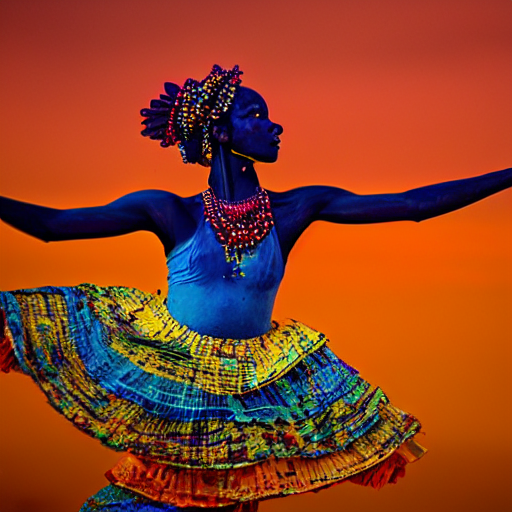

In [14]:
pil_images[0]